# Logistic Regression on Algerian Forest Fire Dataset

In [1]:
#Let's start with importing necessary libraries

import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import seaborn as sns
import scikitplot as skl
sns.set()

In [2]:
#pip install scikit-plot

In [3]:
df=pd.read_csv("C:\\Users\\sonal\\Downloads\\Algerian_forest_fires_dataset_UPDATE.csv",header=1)
df.head

<bound method NDFrame.head of     day month  year Temperature  RH  Ws Rain   FFMC  DMC    DC  ISI   BUI  \
0     1     6  2012          29  57  18     0  65.7  3.4   7.6  1.3   3.4   
1     2     6  2012          29  61  13   1.3  64.4  4.1   7.6    1   3.9   
2     3     6  2012          26  82  22  13.1  47.1  2.5   7.1  0.3   2.7   
3     4     6  2012          25  89  13   2.5  28.6  1.3   6.9    0   1.7   
4     5     6  2012          27  77  16     0  64.8    3  14.2  1.2   3.9   
..   ..   ...   ...         ...  ..  ..   ...   ...  ...   ...  ...   ...   
242  26     9  2012          30  65  14     0  85.4   16  44.5  4.5  16.9   
243  27     9  2012          28  87  15   4.4  41.1  6.5     8  0.1   6.2   
244  28     9  2012          27  87  29   0.5  45.9  3.5   7.9  0.4   3.4   
245  29     9  2012          24  54  18   0.1  79.7  4.3  15.2  1.7   5.1   
246  30     9  2012          24  64  15   0.2  67.3  3.8  16.5  1.2   4.8   

     FWI     Classes    Region  
0    0.5   n

                                               **Data Cleaning**

Observation: In our dataset

1. From index 0-121 we have Bejaia Region
2. From index 122-124 we have irrelevant rows so we need to drop it
3. From index 125 onwards we have Sidi-Bel Abbes Region
Lets drop the unecessary rows

In [4]:
df.drop(index=[122,123,124],inplace=True) #to drop unwanted rows
df.reset_index(drop=True,inplace=True) #Resetting indexes after deleting rows
df['Region']=0

for i in range(len(df)):
    if i < 122:
        df['Region'][i]=0
    else:
        df['Region'][i]=1

In [5]:
df.columns

Index(['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  ', 'Region'],
      dtype='object')

Observation: Column name has some extra space lets remove it.

In [6]:
for i in df.columns:
    df.rename(columns={i:i.strip()},inplace=True)
    
print(df.columns)

Index(['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes', 'Region'],
      dtype='object')


In [7]:
#Finding out Null data in dataset
df.isnull().sum()

day            0
month          0
year           0
Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
Classes        1
Region         0
dtype: int64

In [8]:
df.iloc[165]

day                 14
month                7
year              2012
Temperature         37
RH                  37
Ws                  18
Rain               0.2
FFMC              88.9
DMC               12.9
DC              14.6 9
ISI               12.5
BUI               10.4
FWI            fire   
Classes            NaN
Region               1
Name: 165, dtype: object

From above observation we see that the values have been shifted to left from "DC" so we need to shift it back to their origional places

In [9]:
#Correcting the entries at roq 165 and shifting it to right
df.at[165, 'DC']= 14.6
df.at[165, 'ISI']= 9
df.at[165, 'BUI']= 12.5
df.at[165, 'FWI']= 10.4
df.at[165, 'Classes']= 'fire'
df.iloc[165]

day              14
month             7
year           2012
Temperature      37
RH               37
Ws               18
Rain            0.2
FFMC           88.9
DMC            12.9
DC             14.6
ISI               9
BUI            12.5
FWI            10.4
Classes        fire
Region            1
Name: 165, dtype: object

In [10]:
#Lets check again for Null values
df.isnull().sum()

day            0
month          0
year           0
Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
Classes        0
Region         0
dtype: int64

There are no Null values in the dataset

In [11]:
#Checking for missing values
df.isna().sum()

day            0
month          0
year           0
Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
Classes        0
Region         0
dtype: int64

No missing values as well

In [12]:
#Lets check the unique values in our catagorical variable that is 'Classes'
df['Classes'].unique()

array(['not fire   ', 'fire   ', 'fire', 'fire ', 'not fire', 'not fire ',
       'not fire     ', 'not fire    '], dtype=object)

In [13]:
#We can see that there are extra spaces in the entries that we need to remove
df['Classes']= [i.strip() for i in df['Classes']]
df['Classes'].unique()

array(['not fire', 'fire'], dtype=object)

Extra spaces has been removed

In [14]:
df.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire,0
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire,0
4,5,6,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire,0


Observation: The entries of "year" column are same throughout and doesnot have any impact on dataset

Column "day" and "Month "also can be removed

In [15]:
#Deleting unwanted columns
df.drop(columns= ['year','day','month'], inplace= True)
df.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire,0
4,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire,0


In [16]:
##Lets check the data types of columns
df.dtypes

Temperature    object
RH             object
Ws             object
Rain           object
FFMC           object
DMC            object
DC             object
ISI            object
BUI            object
FWI            object
Classes        object
Region          int64
dtype: object

From our observation we see that columns month,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI are having Catagorical data which needs to be Numerical.

and Region is Numerical and it should be Catagorical

Lets check the datatypes as well

We need to change the datatypes

In [17]:
##Converting datatypes of columns
col=['Temperature','RH','Ws','Rain','FFMC','DMC','DC','ISI','BUI','FWI']
df[col]=df[col].apply(pd.to_numeric)

df['Region']=df['Region'].apply(str)
#Lets check again
df.dtypes

Temperature      int64
RH               int64
Ws               int64
Rain           float64
FFMC           float64
DMC            float64
DC             float64
ISI            float64
BUI            float64
FWI            float64
Classes         object
Region          object
dtype: object

In [18]:
# Lets check for duplicates
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
239    False
240    False
241    False
242    False
243    False
Length: 244, dtype: bool

In [19]:
# Lets check for duplicates
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
239    False
240    False
241    False
242    False
243    False
Length: 244, dtype: bool

Observation: No duplicate data available

# Statistical Information

In [20]:
df.describe()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,32.172131,61.938525,15.504098,0.760656,77.887705,14.673361,49.288115,4.759836,16.673361,7.049180
std,3.633843,14.884200,2.810178,1.999406,14.337571,12.368039,47.619662,4.154628,14.201648,7.428366
min,22.000000,21.000000,6.000000,0.000000,28.600000,0.700000,6.900000,0.000000,1.100000,0.000000
25%,30.000000,52.000000,14.000000,0.000000,72.075000,5.800000,13.275000,1.400000,6.000000,0.700000
50%,32.000000,63.000000,15.000000,0.000000,83.500000,11.300000,33.100000,3.500000,12.450000,4.450000
75%,35.000000,73.250000,17.000000,0.500000,88.300000,20.750000,68.150000,7.300000,22.525000,11.375000
max,42.000000,90.000000,29.000000,16.800000,96.000000,65.900000,220.400000,19.000000,68.000000,31.100000


In [21]:
#Lets check the Catagorical and Numerical column data in our dataset
cat_col=[fea for fea in df.columns if df[fea].dtype == 'O'] #catagorical data
num_col=[fea for fea in df.columns if df[fea].dtype != 'O']  #numarical data

Lets check the distribution of Numerical data

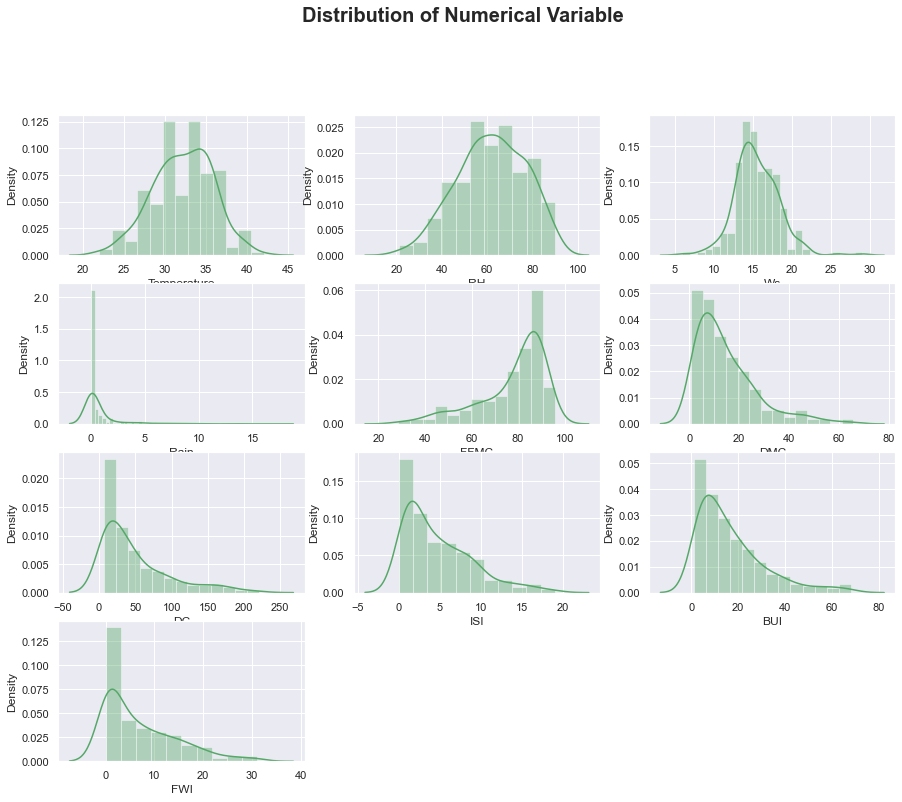

In [22]:
plt.figure(figsize=(15,15))
plt.suptitle('Distribution of Numerical Variable', fontsize=20, fontweight='bold')

for i in range (0, len(num_col)):
    plt.subplot(5,3,i+1)
    sns.distplot(df[num_col[i]], color='g')
    plt.xlabel(num_col[i])

In [23]:
percentage = df.Region.value_counts(normalize=True)*100
percentage

0    50.0
1    50.0
Name: Region, dtype: float64

Text(0.5, 1.0, 'Region Distributions \n 0: Bejaia Region || 1: Sidi-Bel Abbes Region')

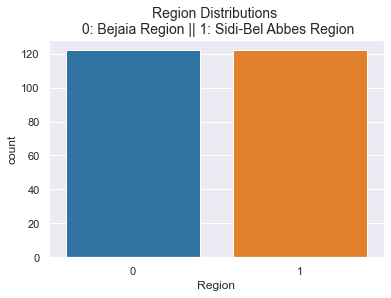

In [24]:
sns.countplot('Region', data=df, palette="tab10")
plt.title('Region Distributions \n 0: Bejaia Region || 1: Sidi-Bel Abbes Region', fontsize=14)

Data is balanced 

<AxesSubplot:>

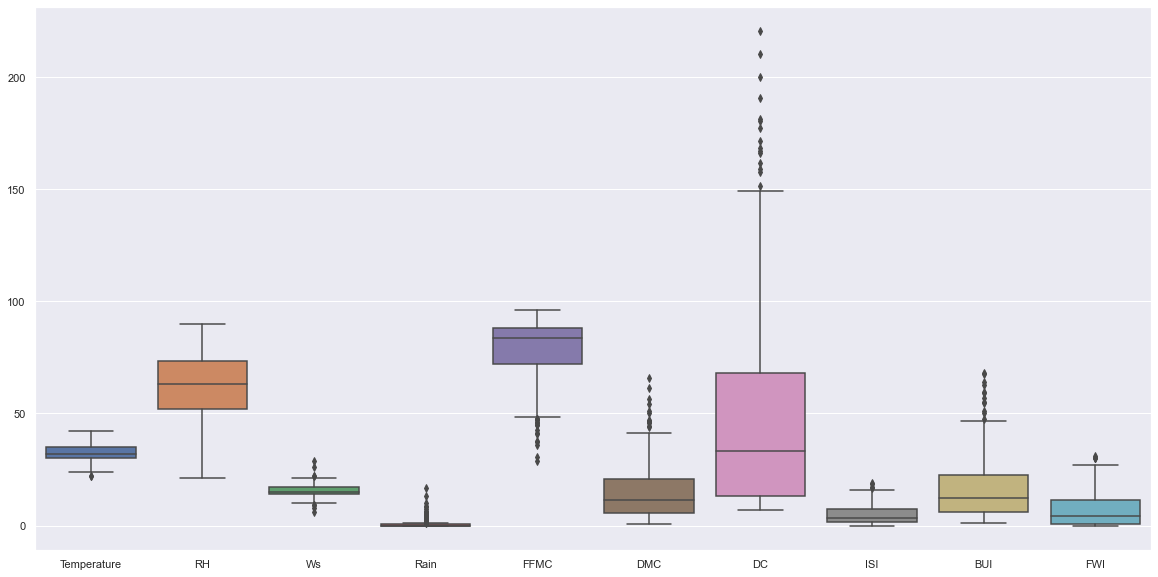

In [25]:
#Outliers
plt.figure(figsize=(20,10))
sns.boxplot(data = df, orient='v')

Temperature, Ws, Rain, FFMC, DMC, DC, ISI, BUI and FWI having outliers.



Let's deal with that. we can either remove such data or simply replace it with their respective mean values. Let's do the latter.

In [26]:
df

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,0
...,...,...,...,...,...,...,...,...,...,...,...,...
239,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,fire,1
240,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0,not fire,1
241,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire,1
242,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire,1


In [27]:
df['Classes']=df['Classes'].map({'not fire': 0,'fire': 1})
df


,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0,0
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0,0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
239,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,1,1
240,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0,0,1
241,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,0,1
242,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,0,1


In [28]:
df1=df.copy()

In [30]:
def remove_outliers_IQR(df,col_name):
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    print("q1",q1)
    print("q3",q3)
    iqr = q3 - q1
    upper_bound = q3 + (1.5 * iqr)
    lower_bound = q1 - (1.5 * iqr)
    print("Upper Bound",upper_bound)
    print("Lower Bound",lower_bound)
    print("IQR", iqr)
    df1[col_name] = np.where(df1[col_name]>upper_bound, upper_bound, np.where(df1[col_name]<lower_bound,lower_bound,df1[col_name]))
    return df1[df1[col_name] > upper_bound]


**Comparision plot between df and df1 columns containing outliers**

In [42]:
def create_comparison_plot(df,df1,column):
 plt.figure(figsize=(16,8))
 plt.subplot(2,2,1)
 sns.distplot(df[column])
 plt.subplot(2,2,2)
 sns.boxplot(df[column])
 plt.subplot(2,2,3)
 sns.distplot(df1[column])
 plt.subplot(2,2,4)
 sns.boxplot(df1[column])
 plt.show()


q1 30.0
q3 35.0
Upper Bound 42.5
Lower Bound 22.5
IQR 5.0


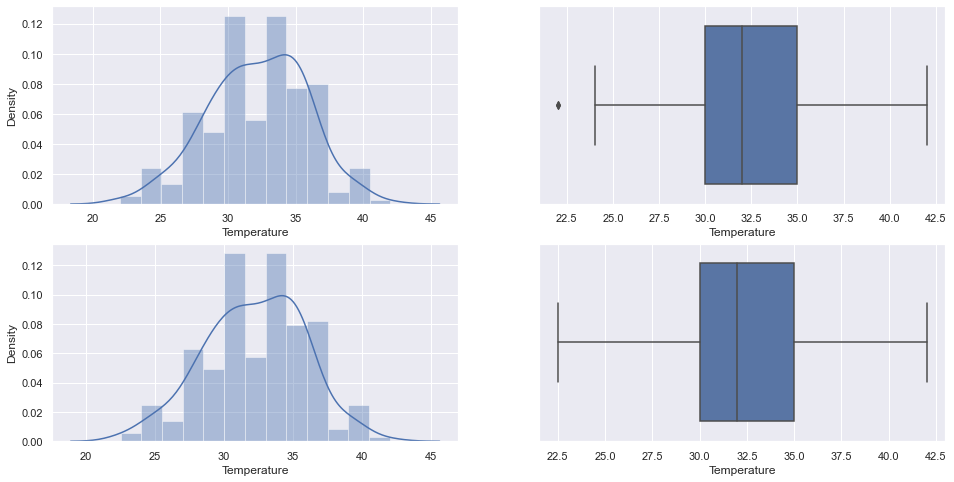

In [32]:
remove_outliers_IQR(df, 'Temperature')
create_comparison_plot(df,df1,"Temperature")

q1 14.0
q3 17.0
Upper Bound 21.5
Lower Bound 9.5
IQR 3.0


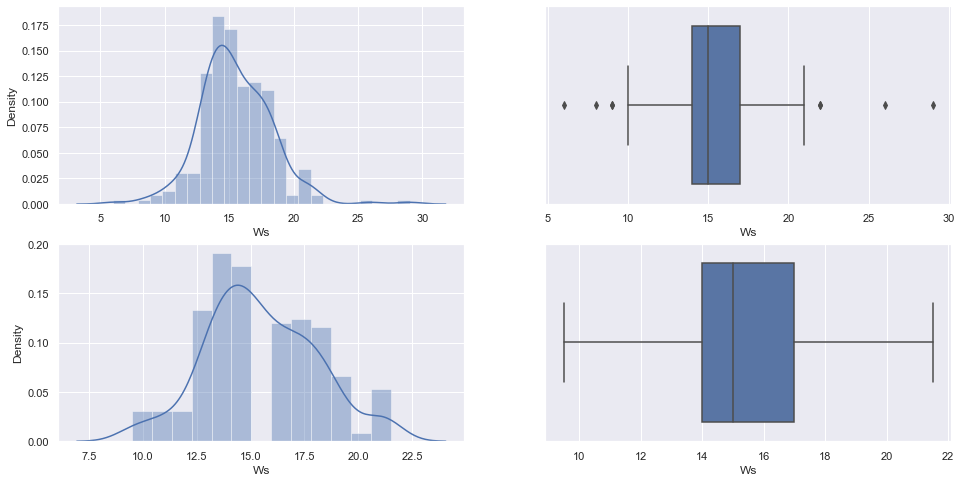

In [33]:
remove_outliers_IQR(df,'Ws')
create_comparison_plot(df,df1,"Ws")

q1 0.0
q3 0.5
Upper Bound 1.25
Lower Bound -0.75
IQR 0.5


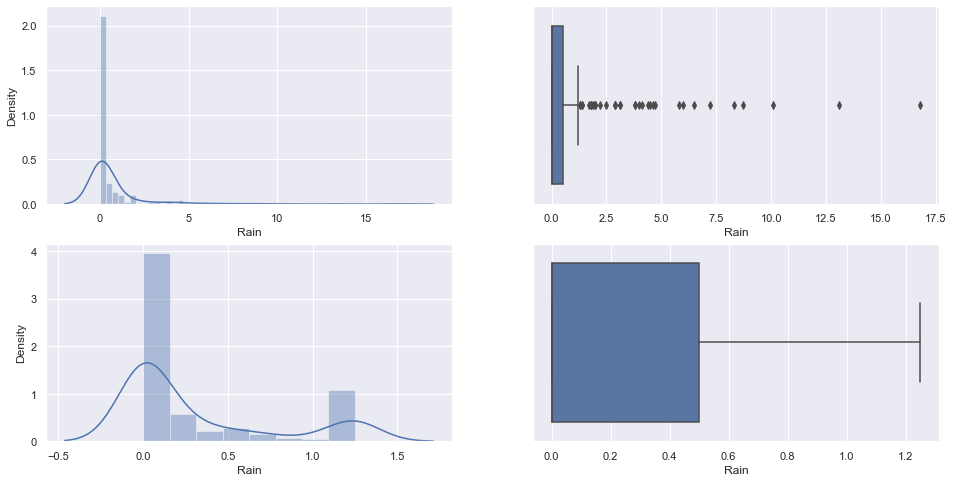

In [34]:
remove_outliers_IQR(df,'Rain')
create_comparison_plot(df,df1,"Rain")

q1 72.075
q3 88.3
Upper Bound 112.63749999999999
Lower Bound 47.73750000000001
IQR 16.224999999999994


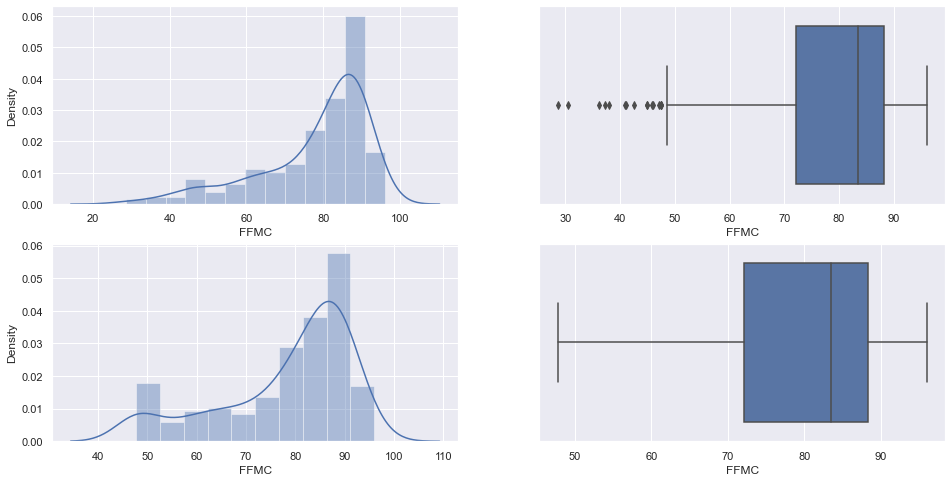

In [35]:
remove_outliers_IQR(df,'FFMC')
create_comparison_plot(df,df1,"FFMC")


q1 5.8
q3 20.75
Upper Bound 43.175
Lower Bound -16.624999999999996
IQR 14.95


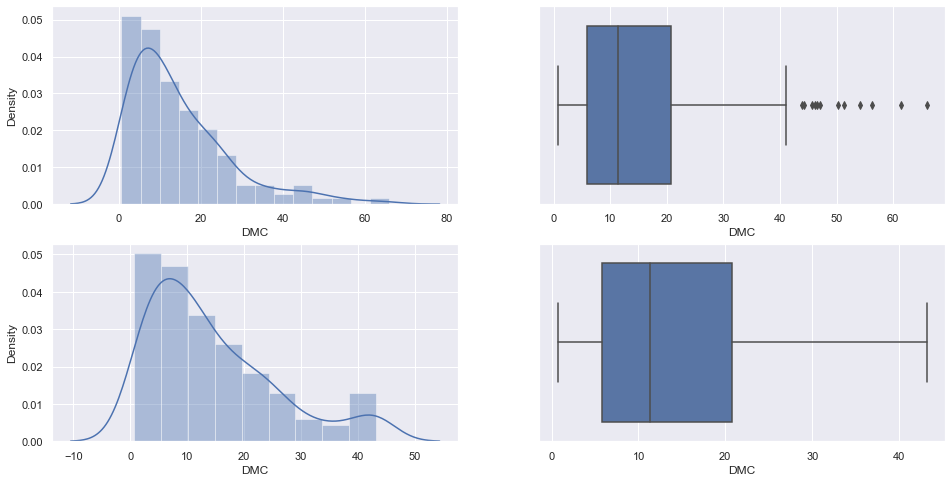

In [36]:
remove_outliers_IQR(df,'DMC')
create_comparison_plot(df,df1,"DMC")

q1 13.274999999999999
q3 68.15
Upper Bound 150.46250000000003
Lower Bound -69.03750000000002
IQR 54.87500000000001


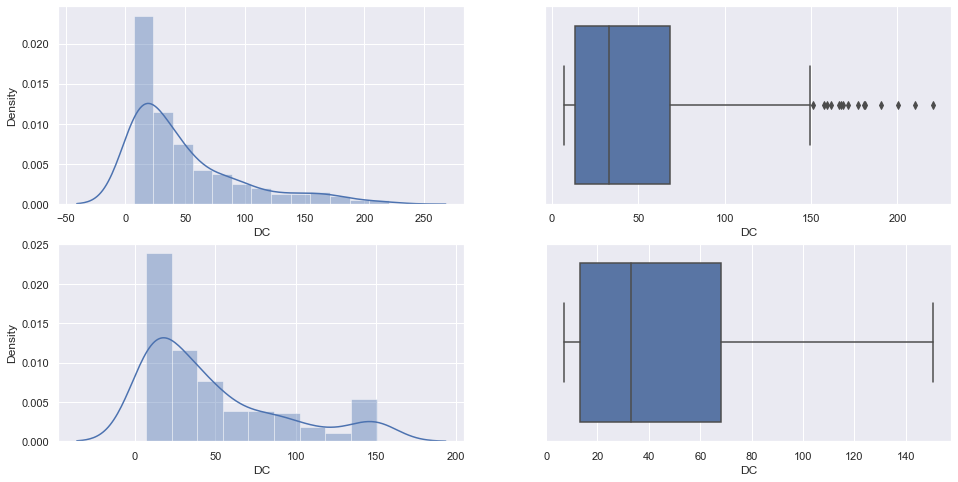

In [37]:
remove_outliers_IQR(df,'DC')
create_comparison_plot(df,df1,"DC")

q1 1.4
q3 7.3
Upper Bound 16.150000000000002
Lower Bound -7.450000000000001
IQR 5.9


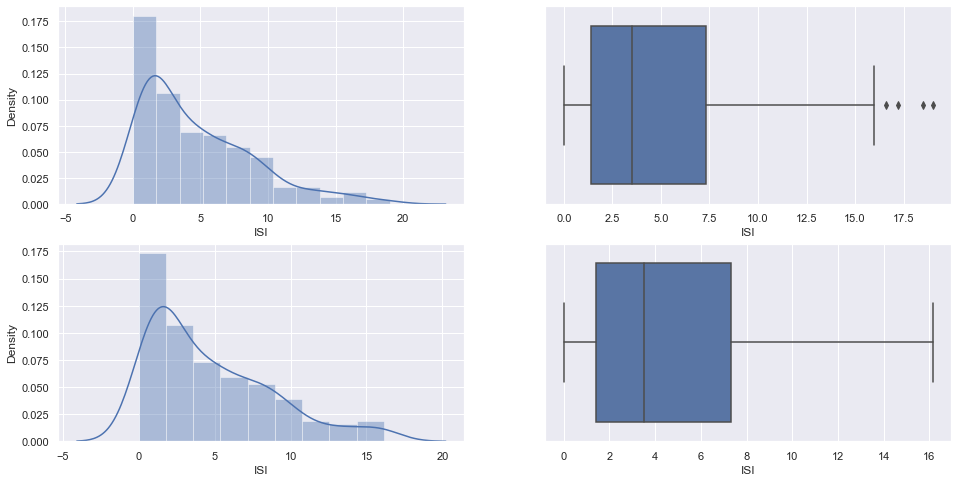

In [38]:
remove_outliers_IQR(df,'ISI')
create_comparison_plot(df,df1,"ISI")

q1 6.0
q3 22.525
Upper Bound 47.3125
Lower Bound -18.787499999999998
IQR 16.525


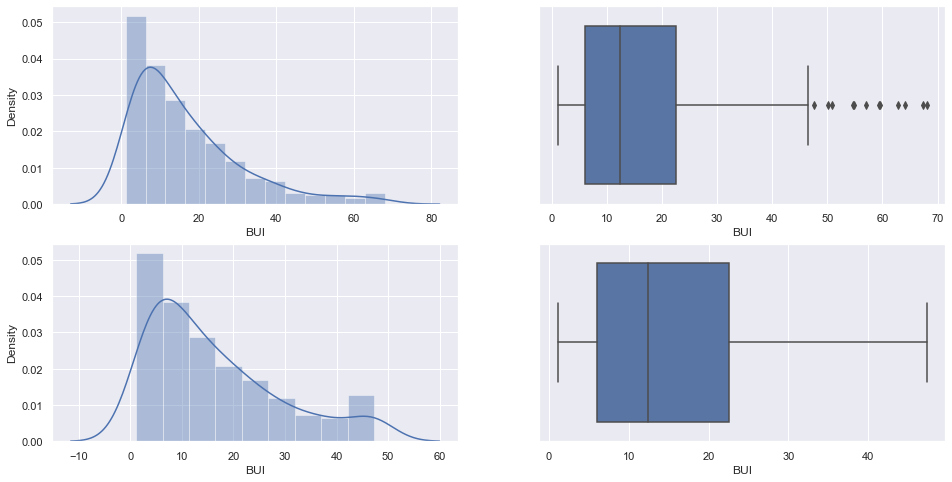

In [39]:
remove_outliers_IQR(df,'BUI')
create_comparison_plot(df,df1,"BUI")

q1 0.7
q3 11.375
Upper Bound 27.387500000000003
Lower Bound -15.312500000000004
IQR 10.675


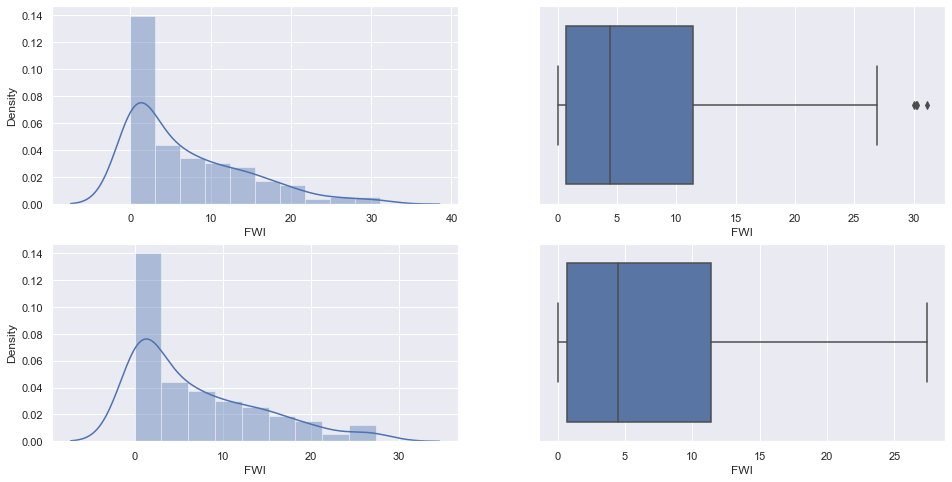

In [40]:
remove_outliers_IQR(df,'FWI')
create_comparison_plot(df,df1,"FWI")

**Regression Analysis**

In [41]:
# Check counts
df1.Classes.value_counts()

1    138
0    106
Name: Classes, dtype: int64

In [43]:
df1

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,29.0,57,18.0,0.00,65.7000,3.4,7.6,1.3,3.4,0.5,0,0
1,29.0,61,13.0,1.25,64.4000,4.1,7.6,1.0,3.9,0.4,0,0
2,26.0,82,21.5,1.25,47.7375,2.5,7.1,0.3,2.7,0.1,0,0
3,25.0,89,13.0,1.25,47.7375,1.3,6.9,0.0,1.7,0.0,0,0
4,27.0,77,16.0,0.00,64.8000,3.0,14.2,1.2,3.9,0.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
239,30.0,65,14.0,0.00,85.4000,16.0,44.5,4.5,16.9,6.5,1,1
240,28.0,87,15.0,1.25,47.7375,6.5,8.0,0.1,6.2,0.0,0,1
241,27.0,87,21.5,0.50,47.7375,3.5,7.9,0.4,3.4,0.2,0,1
242,24.0,54,18.0,0.10,79.7000,4.3,15.2,1.7,5.1,0.7,0,1


**Here Classes is the dependent variable that means Fire depends upon rest of the factors so Classes is our target feature**

                    ***Lets create Independent and Dependent feature and build our model***

In [44]:
#X= Independent feature & Y= Dependent feature: 
X = df1.drop(columns = ['Classes'])
Y = df1['Classes']

In [45]:
X.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Region
0,29.0,57,18.0,0.00,65.7000,3.4,7.6,1.3,3.4,0.5,0
1,29.0,61,13.0,1.25,64.4000,4.1,7.6,1.0,3.9,0.4,0
2,26.0,82,21.5,1.25,47.7375,2.5,7.1,0.3,2.7,0.1,0
3,25.0,89,13.0,1.25,47.7375,1.3,6.9,0.0,1.7,0.0,0
4,27.0,77,16.0,0.00,64.8000,3.0,14.2,1.2,3.9,0.5,0


In [47]:
Y.head(10)

0    0
1    0
2    0
3    0
4    0
5    1
6    1
7    1
8    0
9    0
Name: Classes, dtype: int64

**Lets train our model with Train-Test-Split**

In [59]:
df.shape

(244, 12)

In [49]:
df1.shape

(244, 12)

In [60]:
from sklearn.model_selection import train_test_split #test data is used to validate data
X_train,X_test,Y_train,Y_test=train_test_split(
X,Y,test_size=0.25,random_state=0)

In [61]:
X_train.shape

(183, 11)

In [62]:
Y_train.shape

(183,)

In [63]:
Y_test.shape

(61,)

In [64]:
X_test.shape

(61, 11)

**Feature Scaling**

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [66]:
X_train

array([[ 1.06691859, -0.72230352,  0.19065425, ...,  1.19486681,
         1.31732882,  1.00547949],
       [ 0.78105314, -0.85704515,  0.9836026 , ...,  2.32152949,
         2.66567262, -0.99455037],
       [ 0.78105314, -1.26127006, -0.20581993, ..., -0.02273296,
        -0.15298413,  1.00547949],
       ...,
       [-0.36240866, -0.45282025, -1.79171664, ..., -0.82680829,
        -0.76784227, -0.99455037],
       [-0.36240866,  0.4903712 , -0.60229411, ..., -0.21417947,
        -0.19308357, -0.99455037],
       [ 1.06691859, -2.13709068,  0.9836026 , ...,  1.72325916,
         2.66567262,  1.00547949]])

In [67]:
X_test

array([[ 4.95187691e-01,  5.57742013e-01, -9.98768284e-01,
        -6.75621127e-01,  4.81067597e-01, -5.92377064e-01,
        -6.79378079e-01, -2.28518707e-01, -6.73651082e-01,
        -4.73779678e-01, -9.94550368e-01],
       [ 7.81053141e-01,  1.53517108e-01, -6.02294106e-01,
        -2.65992570e-02, -1.60773405e-01, -8.10403658e-01,
        -9.01750261e-01, -7.71621607e-01, -8.80413308e-01,
        -8.88140600e-01, -9.94550368e-01],
       [ 1.06691859e+00, -5.20191065e-01,  1.38007678e+00,
        -6.75621127e-01,  8.01988097e-01,  1.83797610e-01,
         1.10867580e+00,  1.18827147e+00,  5.28632970e-01,
         1.04999919e+00, -9.94550368e-01],
       [-1.22000501e+00,  1.56830427e+00,  9.83602605e-01,
        -6.75621127e-01,  3.89376025e-01, -1.30160685e-01,
        -9.99242683e-03, -1.10452859e-01, -7.63379862e-02,
        -1.52984126e-01, -9.94550368e-01],
       [-3.62408657e-01,  7.59854465e-01, -6.02294106e-01,
        -6.75621127e-01,  4.19939882e-01, -5.83656001e-01,
  

# Logistic Regression

In [79]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt

In [148]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state = 0)
model.fit(X_train, Y_train)

LogisticRegression(random_state=0)

logistic regression coefficient and intercept

In [149]:
# Show to Coeficient and Intercept
print(model.coef_)
print(model.intercept_)

[[ 0.1374932   0.28417922 -0.08150923 -0.1450757   2.31696886  0.11941263
   0.1780822   2.17602785  0.12795685  1.77368488  0.48960087]]
[1.6227912]


In [231]:
model.score(X_test,Y_test)

0.9016393442622951

**Predicting the Test set results**

In [232]:
y_pred = model.predict(X_test)

In [234]:
from sklearn.metrics import accuracy_score,classification_report
accuracy_score(Y_test,y_pred)

0.9016393442622951

**Model Accuracy achieved= 90.16%**

**classification_report**

In [100]:
print(classification_report(y_pred,Y_test))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90        30
           1       0.88      0.94      0.91        31

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



**Confusion Matrix**

In [70]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(Y_test, y_pred)

In [71]:
con_mat

array([[26,  2],
       [ 4, 29]], dtype=int64)

Observation:

TP(True Positive): 26- Number of positives we predicted correctly

TN(True Negative): 29-Number of negatives we predicted correctly

FP(False Positive): 2 -Number of positives we predicted wrongly

FN(False Negative):  4- Number of negatives we predicted wrongly

In [102]:
TP = con_mat[0][0]
FP = con_mat[0][1]
FN = con_mat[1][0]
TN = con_mat[1][1]

**Precision**

In [103]:
Precision = TP/(TP+FP)
Precision

0.9285714285714286

**Recall**

In [104]:
Recall = TP/(TP+FN)
Recall

0.8666666666666667

**F1 Score**

In [105]:
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
F1_Score

0.896551724137931

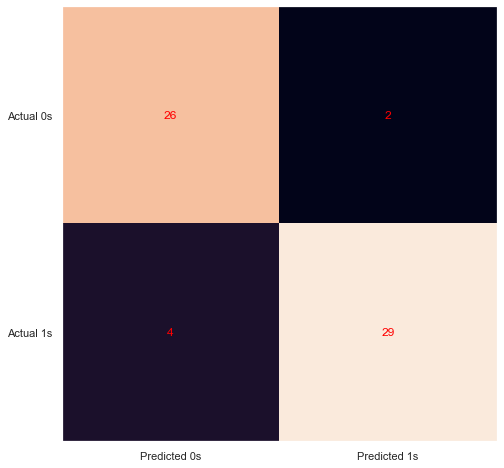

In [141]:
con_mat = confusion_matrix(Y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(con_mat)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, con_mat[i, j], ha='center', va='center', color='red')
plt.show()

**AUC**

In [110]:
auc = roc_auc_score(Y_test, y_pred)
auc

0.9036796536796537

**ROC Curve**

In [106]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
thresholds

array([2, 1, 0], dtype=int64)

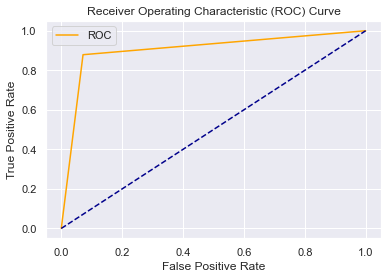

In [109]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Model Improvement

In [167]:
from sklearn.model_selection import GridSearchCV
parameter={'penalty':['l1','l2','elasticnet'],'C':[1,2,3,4,5,6,10,20,30,40,50],'max_iter':[100,200,300]}

In [247]:
model1=GridSearchCV(model,param_grid=parameter,scoring='accuracy',cv=20)

In [248]:
model1.fit(X_train,Y_train)

GridSearchCV(cv=20,
             estimator=LogisticRegression(random_state=0, solver='liblinear'),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 10, 20, 30, 40, 50],
                         'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

In [249]:
print(model1.best_params_)

{'C': 6, 'max_iter': 100, 'penalty': 'l1'}


In [250]:
print(model1.best_score_)

0.9833333333333332


In [251]:
y_pred1 = model1.predict(X_test)

**Accuracy**

In [252]:
score1=accuracy_score(y_pred1,Y_test)
print(score1)

0.9672131147540983


**Model Accuracy achieved after improving= 96.72%**

**Classification Report**

In [220]:
print(classification_report(y_pred1,Y_test))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        31

    accuracy                           0.97        61
   macro avg       0.97      0.97      0.97        61
weighted avg       0.97      0.97      0.97        61



**Confusion Metrix**

In [221]:
con_mat1=confusion_matrix(y_pred1,Y_test)

In [222]:
con_mat1

array([[28,  2],
       [ 0, 31]], dtype=int64)

In [223]:
TP1 = con_mat1[0][0]
FP1 = con_mat1[0][1]
FN1 = con_mat1[1][0]
TN1 = con_mat1[1][1]

**Precision**

In [224]:
Precision = TP1/(TP1+FP1)
Precision

0.9333333333333333

**Recall**

In [225]:
Recall = TP1/(TP1+FN1)
Recall

1.0

**F1 Score**

In [226]:
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
F1_Score

0.9655172413793104

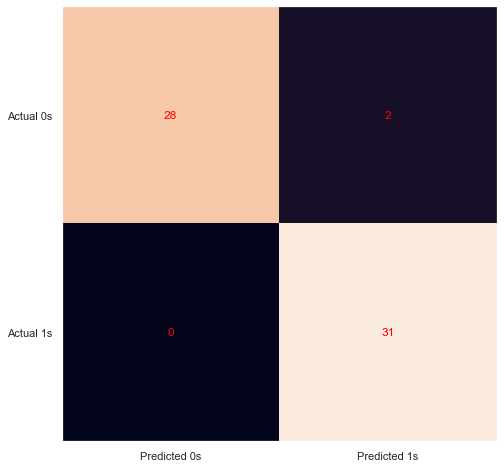

In [227]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(con_mat1)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, con_mat1[i, j], ha='center', va='center', color='red')
plt.show()

**AUC**

In [228]:
auc = roc_auc_score(Y_test, y_pred1)
auc

0.9696969696969697

**ROC Curve**

In [229]:
fpr1, tpr1, thresholds1 = roc_curve(Y_test, y_pred1)
thresholds1

array([2, 1, 0], dtype=int64)

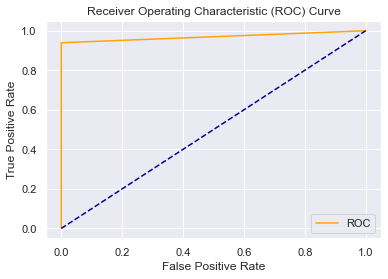

In [230]:
plt.plot(fpr1, tpr1, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()